In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as LA

import re
import os
import gc
import scipy
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from string import punctuation
from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import warnings  
warnings.filterwarnings('ignore')

c:\users\chels\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Fron the input folder, we only use the training data because the test data because we need labels for model performance evaluation. Split it into training (70%) and validation data (30%).

In [2]:
df = pd.read_csv('input/train.csv') 

In [3]:
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}

def clean(text, stem_words=True):

    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

#    stops = set(stopwords.words("english"))
    # Clean the text, with the option to stem words.
    
    # Empty question
    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
#     # all numbers should separate from words, this is too aggressive
    
#     def pad_number(pattern):
#         matched_string = pattern.group(0)
#         return pad_str(matched_string)
#     text = re.sub('[0-9]+', pad_number, text)
    
    # add padding to punctuations and special chars, we still need them later
    
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    
#    def pad_pattern(pattern):
#        matched_string = pattern.group(0)
#       return pad_str(matched_string)
#    text = re.sub('[\!\?\@\^\+\*\/\,\~\|\`\=\:\;\.\#\\\]', pad_pattern, text) 
        
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) # replace non-ascii word with special word
    
    # indian dollar
    
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
    
    # clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text

In [4]:
df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math2324math is divide...,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


In [5]:
df_train, df_test = train_test_split(df, test_size = 0.3)
print (df_train.shape)
print (df_test.shape)

(283003, 6)
(121287, 6)


In [6]:
###### TFIDF(Cosine distance) reatures building
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer = TfidfVectorizer(stop_words='english')

vectorizer = TfidfVectorizer("content", lowercase=True, analyzer="word", use_idf=True)

def cosine_sim(text1, text2):
    # text1 = 'what is the story of kohinoor kohinoor diamond'
    # text2 = 'what would happen if the indian government stole the kohinoor kohinoor diamond back'
    tfidf = vectorizer.fit_transform([text1, text2])
    #   print (tfidf)
    return ((tfidf * tfidf.T).A)[0,1]


# tdidf_cosine function
def tfidf_distance(dataframe):
    # dataframe = df_train_lg.head(2)
    distance_list =[]
    for index, row in dataframe.iterrows(): 
        cosin_dis = cosine_sim(row['question1'],row['question2'])
        distance_list.append(cosin_dis)
    return distance_list

In [7]:
X_train = np.array(tfidf_distance(df_train)).reshape(-1,1)
y_train = np.array(df_train['is_duplicate'])

In [8]:
X_test = np.array(tfidf_distance(df_test)).reshape(-1,1)
y_test = np.array(df_test['is_duplicate'])

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

def train_test_evaluate(classifier):
    """
    Train, test, and evaluate the classifier
    :param classifier: a classifier             
    """
    
    # Declare the model
    clf = classifier()
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # predict
    clf.predict_proba(X_test)
    
    # Update the list of accuracies
    accuracies.append(clf.score(X_test, y_test))
    losses.append(log_loss(y_test, clf.predict_proba(X_test)))

In [14]:
clfs = [LogisticRegression, MultinomialNB, RandomForestClassifier]

# The list of accuracies
accuracies = []

# The List of losses
losses = []

# For each classifer
for classifier in clfs:
    # Call function train_test_evaluate (defined above)
    train_test_evaluate(classifier)

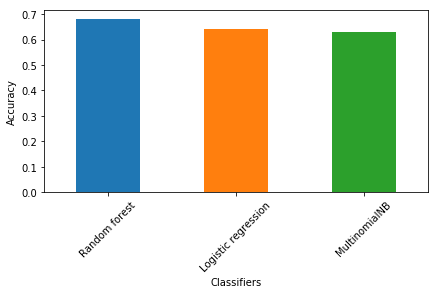

In [16]:
# Convert the accuracies into one-dimensional 1darray with corresponding classifier names as axis labels
clf_accuracies = pd.Series(accuracies,['Logistic regression', 'MultinomialNB', 'Random forest'])

# Sort the array in descending order of the accuracies
clf_accuracies = clf_accuracies.sort_values(ascending=False)

# Draw the bar Plot from clf_accuracies 
clf_accuracies.plot(x='Classifiers', y='Accuracy', kind='bar', rot=45)

# Show the plot
plt.tight_layout()
plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.show()

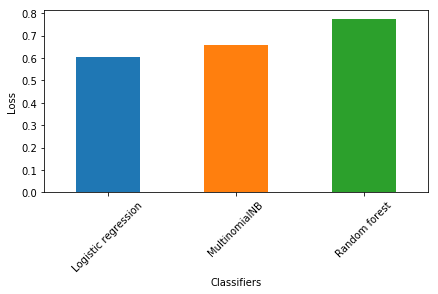

In [18]:
# Convert the accuracies into one-dimensional 1darray with corresponding classifier names as axis labels
clf_losses = pd.Series(losses,['Logistic regression', 'MultinomialNB', 'Random forest'])

# Sort the array in descending order of the accuracies
clf_losses = clf_losses.sort_values(ascending=True)

# Draw the bar Plot from clf_accuracies 
clf_losses.plot(x='Classifiers', y='Loss', kind='bar', rot=45)

# Show the plot
plt.tight_layout()
plt.xlabel('Classifiers')
plt.ylabel('Loss')
plt.show()